<a href="https://colab.research.google.com/github/RyanFahrezaPutra/Bangkit-Capstone-project/blob/main/fish_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib
import urllib.request
import seaborn as sns
import shutil
from google.colab import files
from shutil import copyfile
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from collections import Counter
from shutil import copyfile
from sklearn.model_selection import train_test_split

import PIL
import PIL.Image
from PIL import Image

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = '/content/drive/Shareddrives/C241-PS501/ML/dataset/data'

In [ ]:
classdir_list = ['Bacterial diseases - Aeromoniasis', 'Bacterial gill disease', 'Bacterial Red disease', 'Parasitic diseases', 'Viral diseases White tail disease', 'Healthy Fish', 'Fungal diseases Saprolegniasis']

In [ ]:
# Fungsi untuk mendapatkan daftar kelas dan jumlah masing-masing kelas
def get_class_distribution(dataset_dir):
    class_counts = Counter()

    # Loop melalui subdirektori dalam dataset_dir
    for root, dirs, files in os.walk(dataset_dir):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            num_images = len([f for f in os.listdir(class_dir)
                             if os.path.isfile(os.path.join(class_dir, f))])
            # Nama kelas diambil dari nama subdirektori terakhir
            class_name = os.path.basename(class_dir)
            class_counts[class_name] += num_images

    return class_counts


# Mendapatkan jumlah masing-masing kelas
class_counts = get_class_distribution(dataset_dir)

# Menghitung total jumlah kelas dan total jumlah file
num_classes = len(class_counts)
total_file_count = sum(class_counts.values())

# Membuat DataFrame dari hasil penghitungan
class_counts_df = pd.DataFrame.from_dict(
    class_counts, orient='index', columns=['Jumlah'])
class_counts_df.index.name = 'Genre'
class_counts_df.reset_index(inplace=True)

# Menampilkan tabel
print(class_counts_df)

# Menampilkan total jumlah kelas dan total jumlah file
print(f"\nTotal Jenis Genre Seni: {num_classes}")
print(f"Total Jumlah FIle: {total_file_count}")

                               Genre  Jumlah
0              Bacterial Red disease     250
1  Bacterial diseases - Aeromoniasis     250
2             Bacterial gill disease     250
3     Fungal diseases Saprolegniasis     250
4                       Healthy Fish     250
5                 Parasitic diseases     250
6  Viral diseases White tail disease     250

Total Jenis Genre Seni: 7
Total Jumlah FIle: 1750


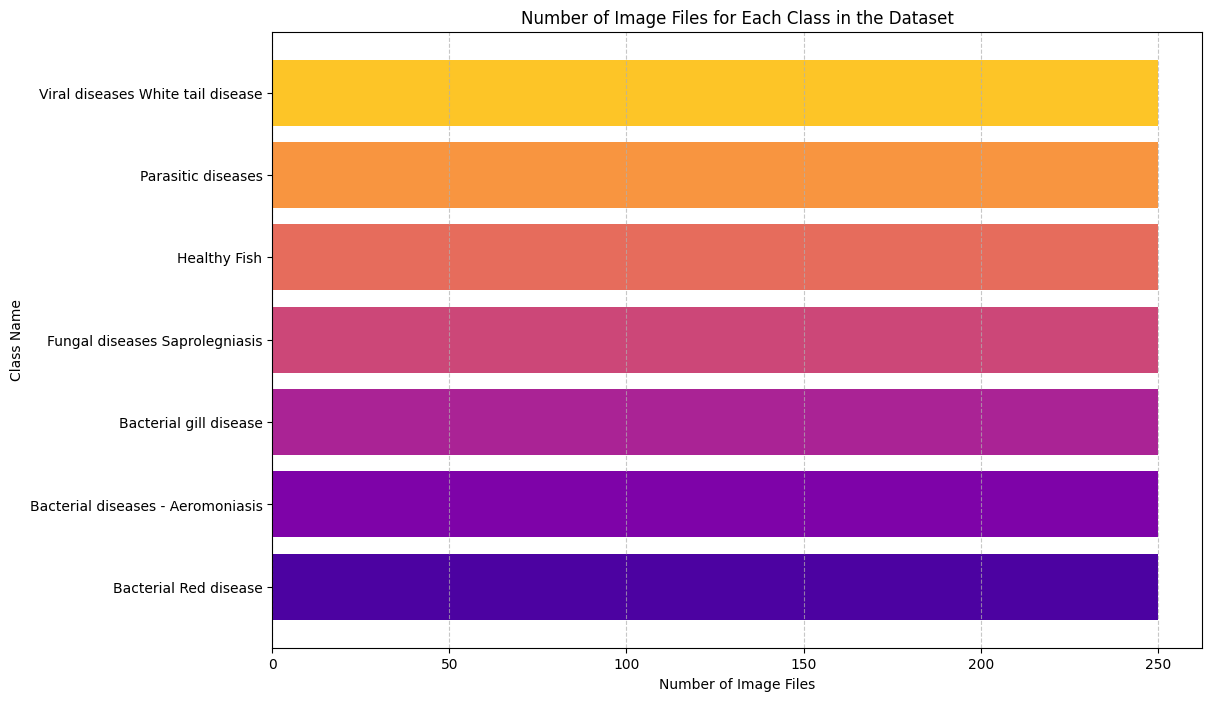

In [ ]:
# Mengurutkan kelas berdasarkan jumlah file
sorted_class_counts = sorted(
    class_counts.items(), key=lambda x: x[1], reverse=False)
sorted_class_names = [item[0] for item in sorted_class_counts]
sorted_file_counts = [item[1] for item in sorted_class_counts]

# Setel palet warna berdasarkan jumlah kelas
palette = sns.color_palette("plasma", len(sorted_class_counts))

# Membuat plot
plt.figure(figsize=(12, 8))
plt.barh(sorted_class_names, sorted_file_counts, color=palette)
plt.xlabel('Number of Image Files')
plt.ylabel('Class Name')
plt.title('Number of Image Files for Each Class in the Dataset')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.show()

In [ ]:
# Path ke direktori dataset asli
original_dataset_dir = '/content/drive/Shareddrives/C241-PS501/ML/dataset/data'

# Path ke direktori baru untuk dataset yang sudah dipisah
base_dir = '/content/drive/Shareddrives/C241-PS501/ML/dataset/dataset'
os.makedirs(base_dir, exist_ok=True)

# Membuat sub-direktori untuk data training dan validasi
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

# Daftar nama kelas (nama direktori di dalam original_dataset_dir)
class_names = os.listdir(original_dataset_dir)

# Memisahkan data menjadi bagian training dan validation
for class_name in class_names:
    # Path ke direktori kelas di dataset asli
    class_original_dir = os.path.join(original_dataset_dir, class_name)

    # Path ke direktori kelas di dataset baru untuk training dan validasi
    class_train_dir = os.path.join(train_dir, class_name)
    os.makedirs(class_train_dir, exist_ok=True)
    class_validation_dir = os.path.join(validation_dir, class_name)
    os.makedirs(class_validation_dir, exist_ok=True)

    # Memisahkan path gambar menjadi bagian training dan validasi
    image_paths = [os.path.join(class_original_dir, image_name) for image_name in os.listdir(class_original_dir)]
    train_image_paths, validation_image_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

    # Menyalin gambar ke direktori training
    for image_path in train_image_paths:
        image_name = os.path.basename(image_path)
        target_path = os.path.join(class_train_dir, image_name)
        copyfile(image_path, target_path)

    # Menyalin gambar ke direktori validation
    for image_path in validation_image_paths:
        image_name = os.path.basename(image_path)
        target_path = os.path.join(class_validation_dir, image_name)
        copyfile(image_path, target_path)

print("Pemisahan dataset selesai.")


Pemisahan dataset selesai.


In [ ]:
# Path ke direktori train dan validasi
train_dir = '/content/drive/Shareddrives/C241-PS501/ML/dataset/dataset/train'
validation_dir = '/content/drive/Shareddrives/C241-PS501/ML/dataset/dataset/validation'

# Fungsi untuk menghitung jumlah file dalam direktori
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Menghitung jumlah file dalam direktori train dan validasi
num_train_files = count_files_in_directory(train_dir)
num_validation_files = count_files_in_directory(validation_dir)

print(f"Jumlah file dalam direktori train: {num_train_files}")
print(f"Jumlah file dalam direktori validation: {num_validation_files}")


Jumlah file dalam direktori train: 1400
Jumlah file dalam direktori validation: 350


In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.2],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=50,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_dataset = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(299, 299),
    batch_size=50,
    class_mode='categorical'
)

Found 1398 images belonging to 7 classes.
Found 349 images belonging to 7 classes.


In [ ]:
class_indices = validation_dataset.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

# Cetak jumlah kelas dan nama kelas
print(f"Jumlah kelas: {num_classes}")
print("Nama kelas:")
for class_name in class_names:
    print(class_name)


Jumlah kelas: 7
Nama kelas:
Bacterial Red disease
Bacterial diseases - Aeromoniasis
Bacterial gill disease
Fungal diseases Saprolegniasis
Healthy Fish
Parasitic diseases
Viral diseases White tail disease


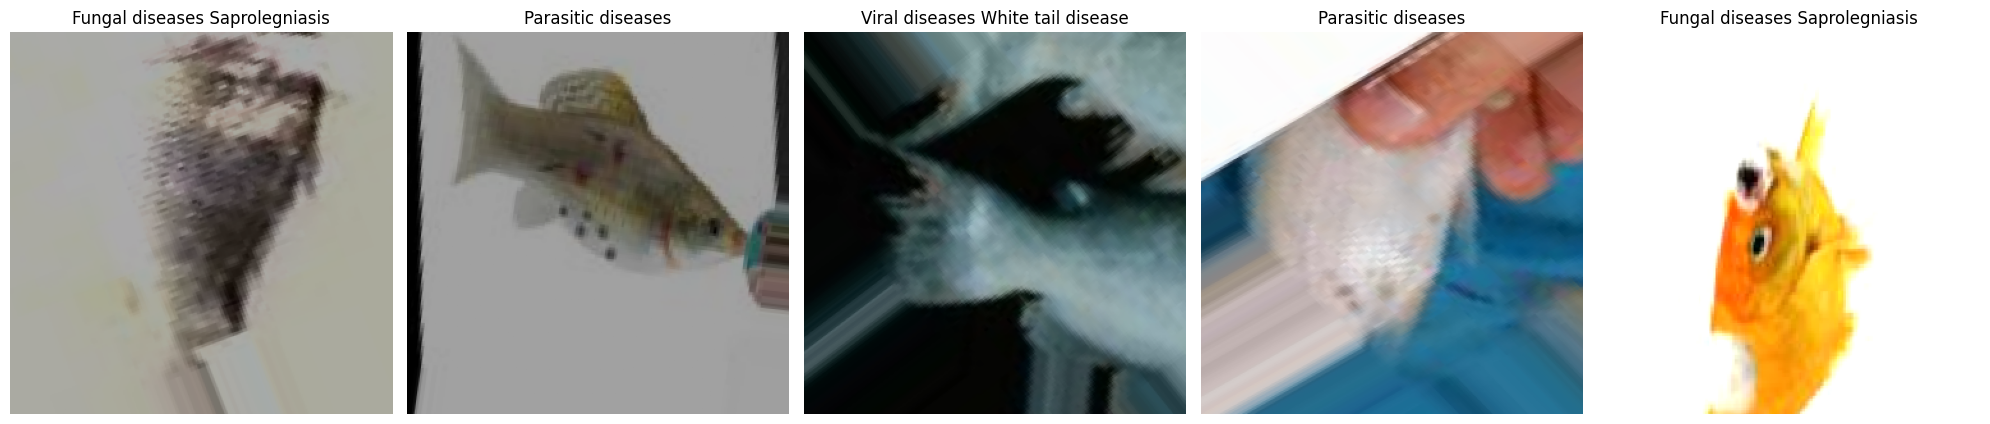

In [ ]:
# Menampilkan beberapa contoh gambar
def plot_images(images_arr, labels_arr, class_indices, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        label = list(class_indices.keys())[
            list(class_indices.values()).index(np.argmax(lbl))]
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Mendapatkan batch gambar dan label
images, labels = next(train_dataset)

# Menampilkan 5 contoh gambar
plot_images(images[:5], labels[:5], class_indices, num_images=5)

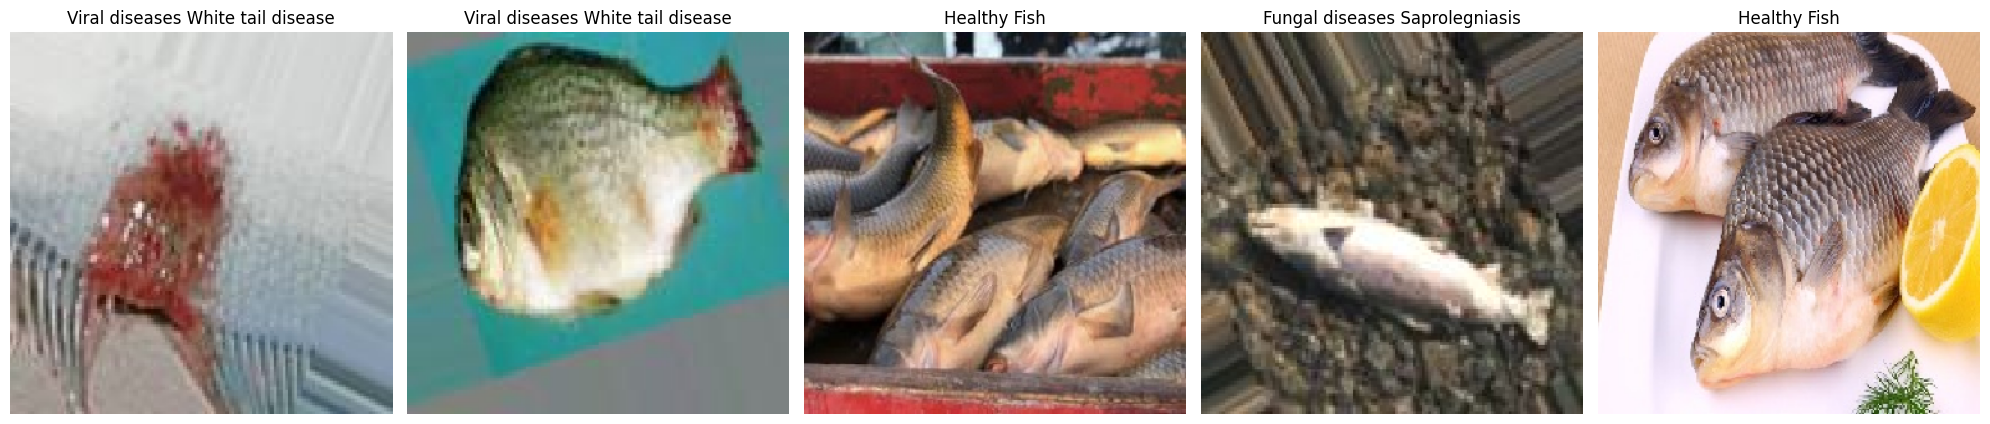

In [ ]:
# Mendapatkan batch gambar dan label
images, labels = next(validation_dataset)

# Menampilkan 5 contoh gambar
plot_images(images[:5], labels[:5], class_indices, num_images=5)

In [ ]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3),
    pooling='avg'
)

for layer in base_model.layers:
  layer.trainable = False

model = base_model.output
model = Dense(128, activation='relu')(model)
model = Dropout(.5)(model)
model = Dense(256, activation='relu')(model)
model = Dropout(.5)(model)
model = Dense(512, activation='relu')(model)
model = Dropout(.5)(model)
output_layer = Dense(num_classes, activation='softmax')(model)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# @title Teks judul default
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1
)

Epoch 1/50
28/28 [==============================] - 794s 28s/step - loss: 1.9659 - accuracy: 0.1509 - val_loss: 1.9187 - val_accuracy: 0.2493
Epoch 2/50
28/28 [==============================] - 760s 27s/step - loss: 1.9305 - accuracy: 0.1617 - val_loss: 1.9016 - val_accuracy: 0.3181
Epoch 3/50
28/28 [==============================] - 763s 27s/step - loss: 1.9259 - accuracy: 0.1760 - val_loss: 1.8846 - val_accuracy: 0.3381
Epoch 4/50
28/28 [==============================] - 760s 27s/step - loss: 1.8968 - accuracy: 0.2210 - val_loss: 1.8588 - val_accuracy: 0.3410
Epoch 5/50
28/28 [==============================] - 749s 27s/step - loss: 1.8729 - accuracy: 0.2532 - val_loss: 1.8252 - val_accuracy: 0.3467
Epoch 6/50
28/28 [==============================] - 739s 27s/step - loss: 1.8548 - accuracy: 0.2668 - val_loss: 1.7885 - val_accuracy: 0.3725
Epoch 7/50
28/28 [==============================] - 738s 26s/step - loss: 1.8241 - accuracy: 0.2740 - val_loss: 1.7563 - val_accuracy: 0.3782
Epoch 

KeyboardInterrupt: 